In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# El siguiente código lee el goal y el mapa del fichero

def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(numeros[0],numeros[1])

In [3]:
def visualiza_mapa(mapa,destino):
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5) # vemos que se puede omitir
    plt.ylim(-0.5, len(mapa) - 0.5) # vemos que se puede omitir
    plt.gca().add_patch(plt.Rectangle((destino[0] - 0.5, destino[1] - 0.5), 1, 1, edgecolor='black', facecolor='red', lw=5))

In [4]:
def genera_estados(mapa):
    estados = []
    for i in range(0,mapa.shape[1]):
        for j in range(0,mapa.shape[0]):
            estados.append(tuple([i,j]))
    return estados

In [5]:
def obtiene_indice_estado(estado):
    return int(estado[0]*mapa.shape[0]+estado[1])

In [6]:
def es_obstaculo(estado,mapa):
    return mapa[estado[1],estado[0]] == 1

In [7]:
acciones = ['esperar','N','NE','E','SE','S','SO','O','NO']

In [8]:
def aplica_accion(estado,accion,mapa):
    if es_obstaculo(estado,mapa):
        return estado
    x = estado[0]
    y = estado[1]
    
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x,y

In [9]:
def obtiene_posibles_errores(accion):
    if accion=='N':
        errores = ['NE','NO']
    elif accion=='S':
        errores = ['SE','SO']
    elif accion=='E':
        errores = ['NE','SE']
    elif accion=='O':
        errores = ['NO', 'SO']
    elif accion=='NE':
        errores = ['N','E']
    elif accion=='NO':
        errores = ['N','O']
    elif accion=='SE':
        errores = ['S','E']
    elif accion == 'SO':
        errores = ['S','O']
    else:
        errores = []
    return errores

In [10]:
K = 1000
def obtiene_recompensa(estado,destino,mapa):
    if es_obstaculo(estado,mapa):
        valor = -K
    else:
        valor = - np.sqrt((estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)
    return valor

In [11]:
def crea_recompensas_sistema(estados,destino,mapa,acciones):
    matriz = []
    for e in estados:
        r = obtiene_recompensa(e,destino,mapa)
        fila = [r]*len(acciones)
        if e != destino:
            fila[0]=-100
        matriz.append(fila)
    return np.array(matriz)

In [12]:
def visualiza_politica(politica,mapa,destino,estados):
    visualiza_mapa(mapa,destino)
    for p in zip(estados,politica):
        accion = p[1]
        if accion=='esperar':
            continue
        estado = p[0]
        e1 = aplica_accion(estado,accion,mapa)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0)*0.6, (y1 - y0)*0.6,
         head_width=0.3, head_length=0.3, fc='black', ec='black')

In [13]:
# ahora podemos hacer la matriz de transición SXS 
def crea_transiciones_movimiento(accion, prob_error,estados,mapa):
    matriz = []
    for e0 in estados:
        fila = [0]*len(estados)
        if es_obstaculo(e0,mapa):
            fila[obtiene_indice_estado(e0)]=1
        else:
            goal = aplica_accion(e0,accion,mapa)
            errores = obtiene_posibles_errores(accion)
            if len(errores)==0:
                fila[obtiene_indice_estado(goal)] = 1
            else:
                fila[obtiene_indice_estado(goal)] = 1 - prob_error
                for error in errores:
                    goal_error = aplica_accion(e0,error,mapa)
                    fila[obtiene_indice_estado(goal_error)] = prob_error/len(errores)
        matriz.append(fila)
    return np.array(matriz)

In [14]:
def crea_transiciones_sistema(prob_error,estados,mapa):
    return np.array([crea_transiciones_movimiento('esperar',prob_error,estados,mapa), 
                     crea_transiciones_movimiento('N',prob_error,estados,mapa),
                     crea_transiciones_movimiento('NE',prob_error,estados,mapa),
                     crea_transiciones_movimiento('E',prob_error,estados,mapa),
                     crea_transiciones_movimiento('SE',prob_error,estados,mapa),
                     crea_transiciones_movimiento('S',prob_error,estados,mapa),
                     crea_transiciones_movimiento('SO',prob_error,estados,mapa),
                     crea_transiciones_movimiento('O',prob_error,estados,mapa),
                     crea_transiciones_movimiento('NO',prob_error,estados,mapa)])

In [15]:
mapa,destino = lee_mapa("../data/map2.txt")

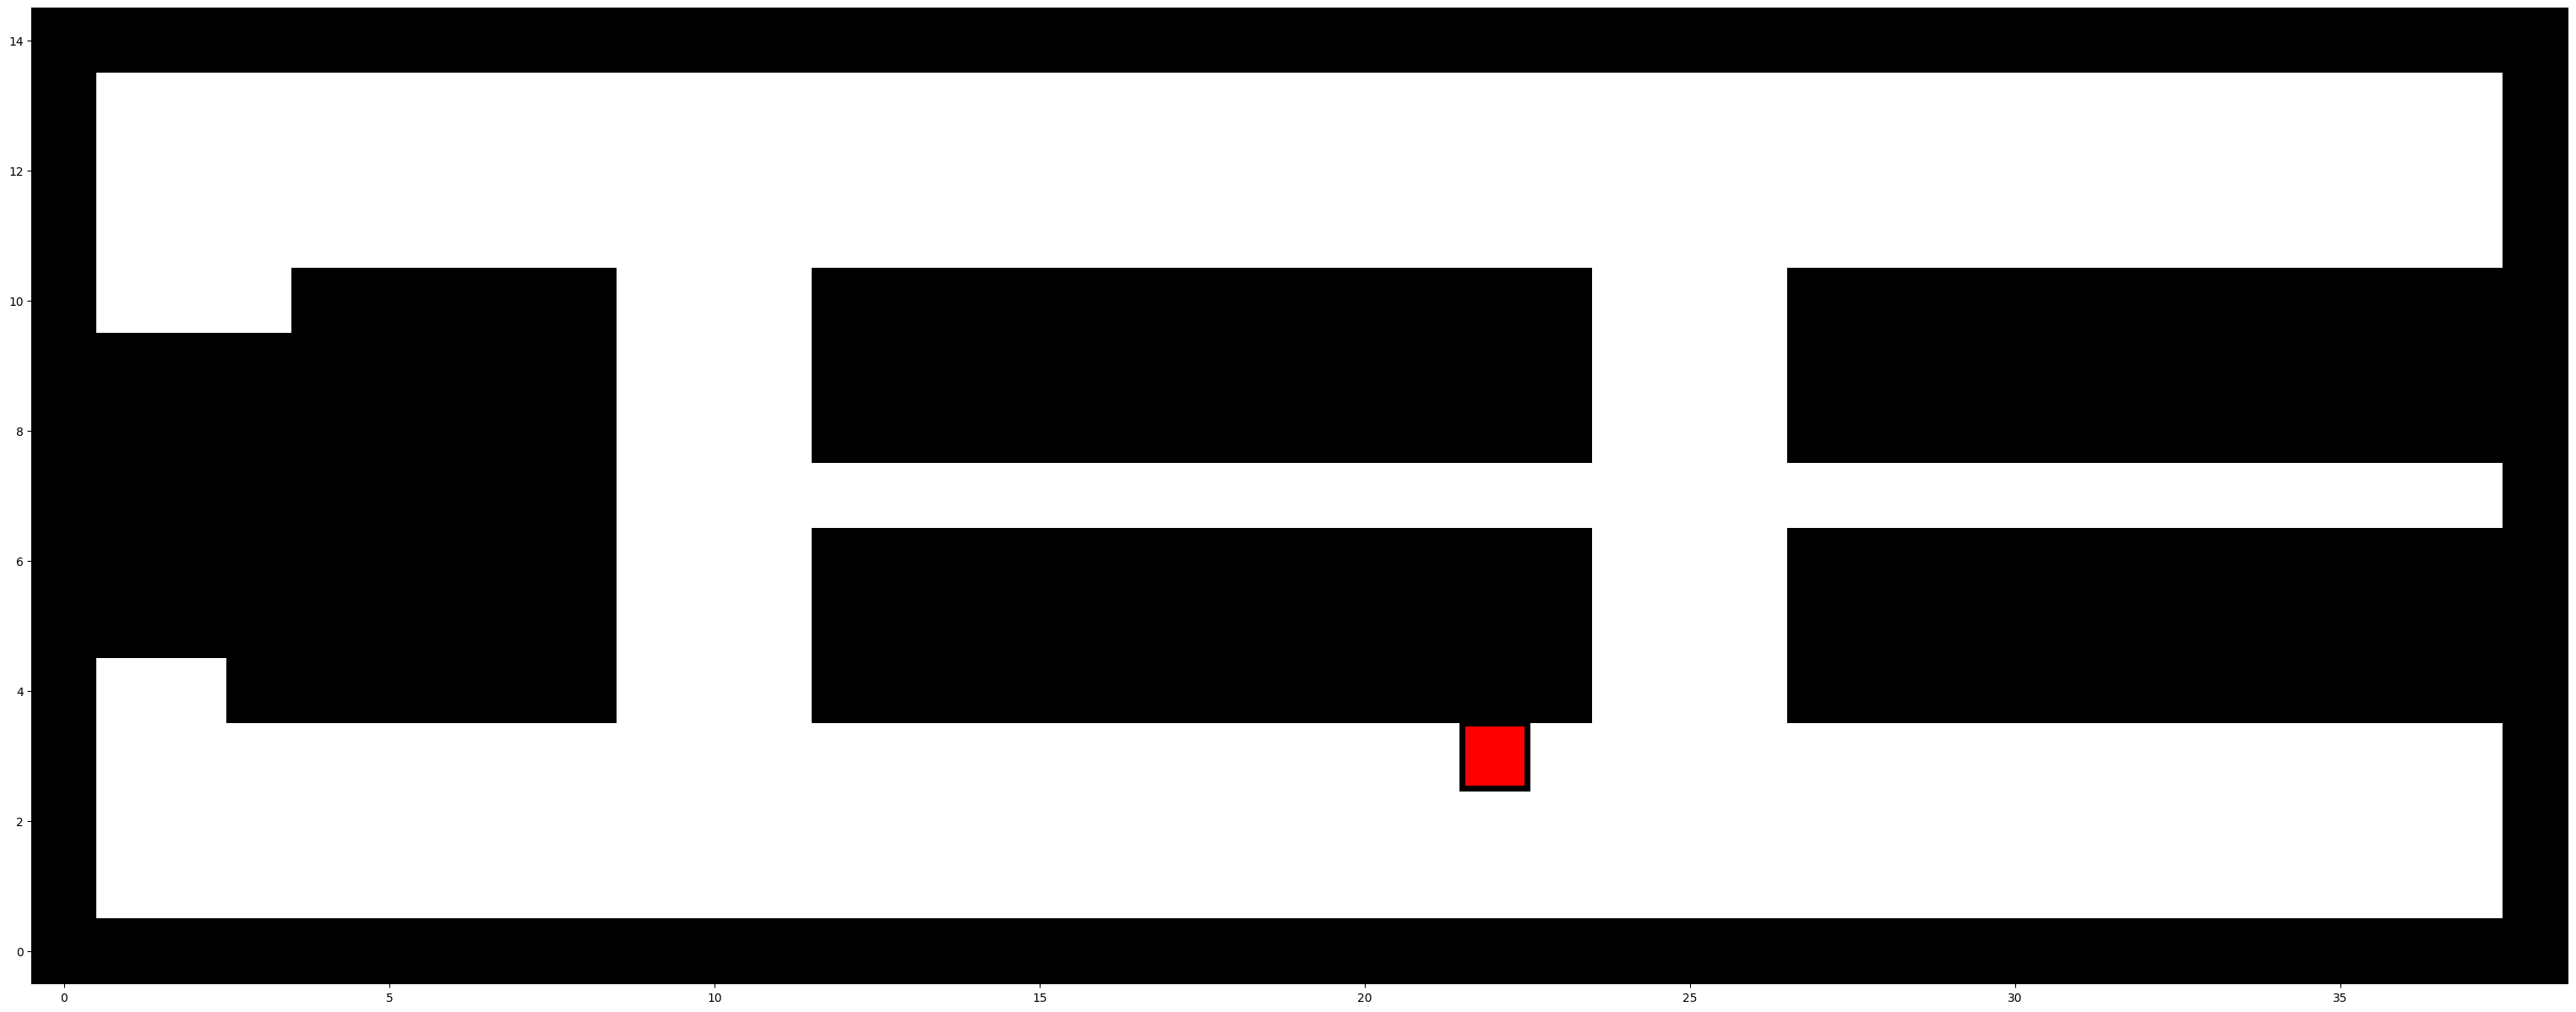

In [16]:
visualiza_mapa(mapa,destino)

In [17]:
estados = genera_estados(mapa)

In [18]:
nav_transiciones_sistema = crea_transiciones_sistema(0.2,estados,mapa)
indices_nav_acciones = {'esperar': 0, 'N': 1, 'NE': 2, 'E': 3, 'SE': 4, 'S': 5, 'SO': 6, 'O': 7, 'NO': 8}

In [19]:
nav_recompensas_sistema = crea_recompensas_sistema(estados,destino,mapa,acciones)

In [61]:
np.random.choice(9)

2

In [25]:
import sarsa as sarsa

modelo_sarsa = sarsa.SARSA(
    nav_transiciones_sistema,
    nav_recompensas_sistema,
    max_iteraciones=50000
)

modelo_sarsa.entrenar()

{0: {0: -200.0000006169055,
  1: -1282.350334290476,
  2: -1119.3892154086377,
  3: -1102.918043926847,
  4: -1125.5296095058495,
  5: -1100.083029057375,
  6: -1100.0330898580999,
  7: -1100.105126175157,
  8: -1100.2875536444208},
 1: {0: -206.17139188146342,
  1: -1100.0088250299698,
  2: -1141.540356886166,
  3: -1116.7687896385005,
  4: -1130.3662476633858,
  5: -1104.8007849011137,
  6: -1116.9208487650092,
  7: -1100.3753380112837,
  8: -1116.9210243634564},
 2: {0: -200.0000019943961,
  1: -1104.8103610715411,
  2: -1100.1197440256478,
  3: -1118.0767246284518,
  4: -1104.1686420572803,
  5: -1145.2577253668976,
  6: -1119.9781128316347,
  7: -1102.6754869698543,
  8: -1506.640864754494},
 3: {0: -200.02864138451994,
  1: -1101.0586271572959,
  2: -1107.0034178126116,
  3: -1506.6398859702967,
  4: -1119.4928367521516,
  5: -1100.148050639189,
  6: -1106.014930581875,
  7: -1142.1325005861818,
  8: -1155.8493371080253},
 4: {0: -211.33628103591204,
  1: -1283.8680504809533,
  2

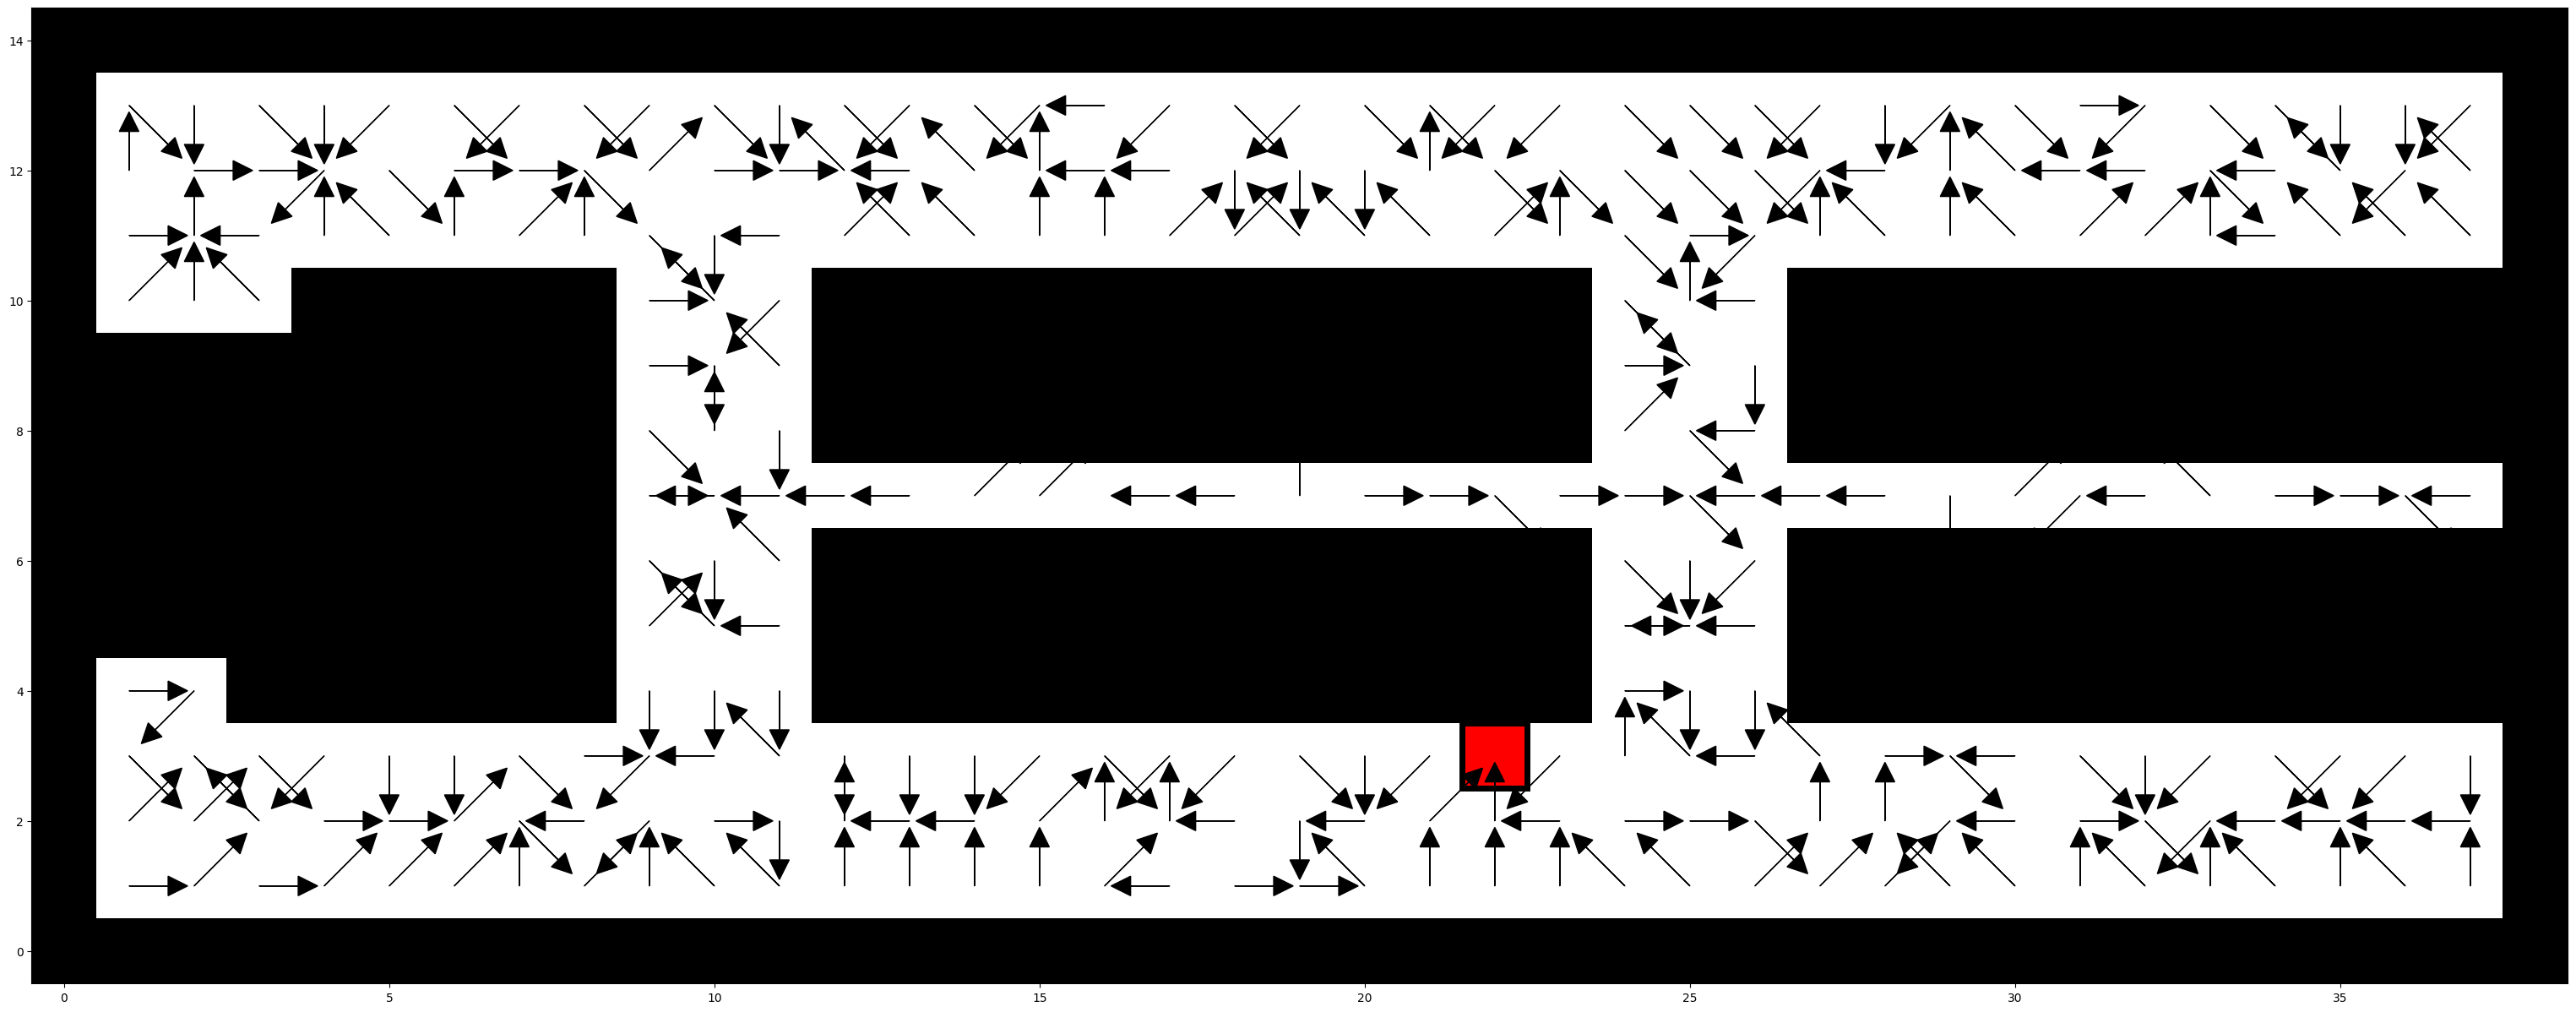

In [26]:
politica_sarsa = modelo_sarsa.obtener_politica()
politica_sarsa_procesable = [acciones[i] for i in politica_sarsa.values()]

visualiza_politica(politica_sarsa_procesable,mapa,destino,estados)